# Prologue

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', 100)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## definitions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## data

In [3]:
path = 'data/cirrhosis.csv'
df = pd.read_csv(path)

original_df = df.copy()
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


* What is the target? (You are required to complete a classification task for this project)
  * Status is the target. A patient can be Censored (C), meaning they were alive at the end of the observation period, Censored due to liver transplant (CL), or Died (D)

* What does one row represent? (A person? A business? An event? A product?)
  * A person

* How many features does the data have?
  * 19 features, plus the N_Days column, which the source lists as "other"

* How many rows are in the dataset?
  * 418

* What opportunities exist for dimensionality reduction or feature selection with this dataset?
  *

* What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
  *

# Model 1 - dropping na rows

## Preprocessing

In [4]:
df = df.drop('ID', axis=1)

### Visualize

In [5]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

(418, 19)

In [6]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


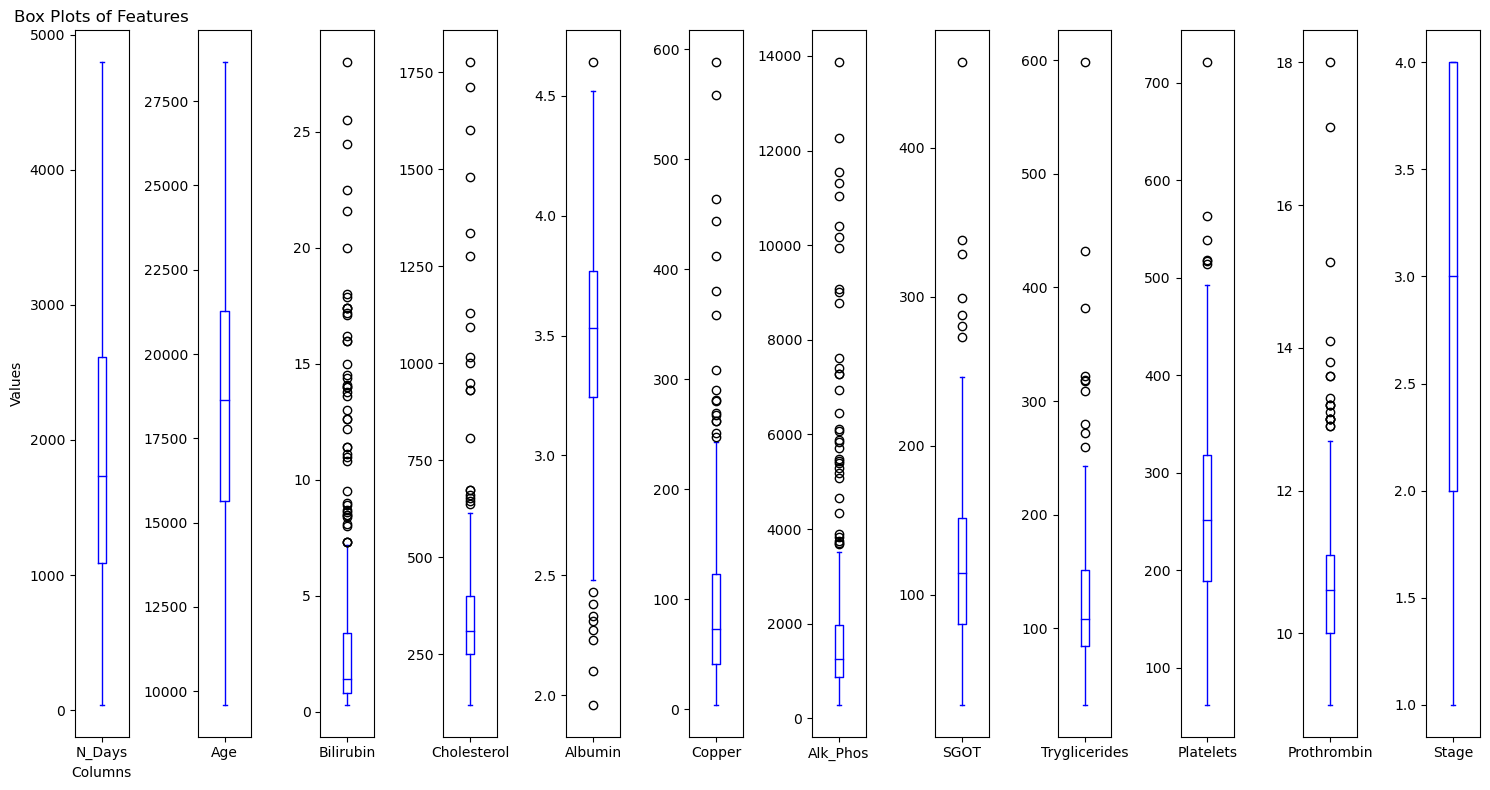

In [7]:
ax = df.plot(kind='box', subplots=True, figsize=(15, 8), color='blue');
ax[0].set_xlabel('Columns');
ax[0].set_ylabel('Values');
ax[0].set_title('Box Plots of Features');

plt.tight_layout();

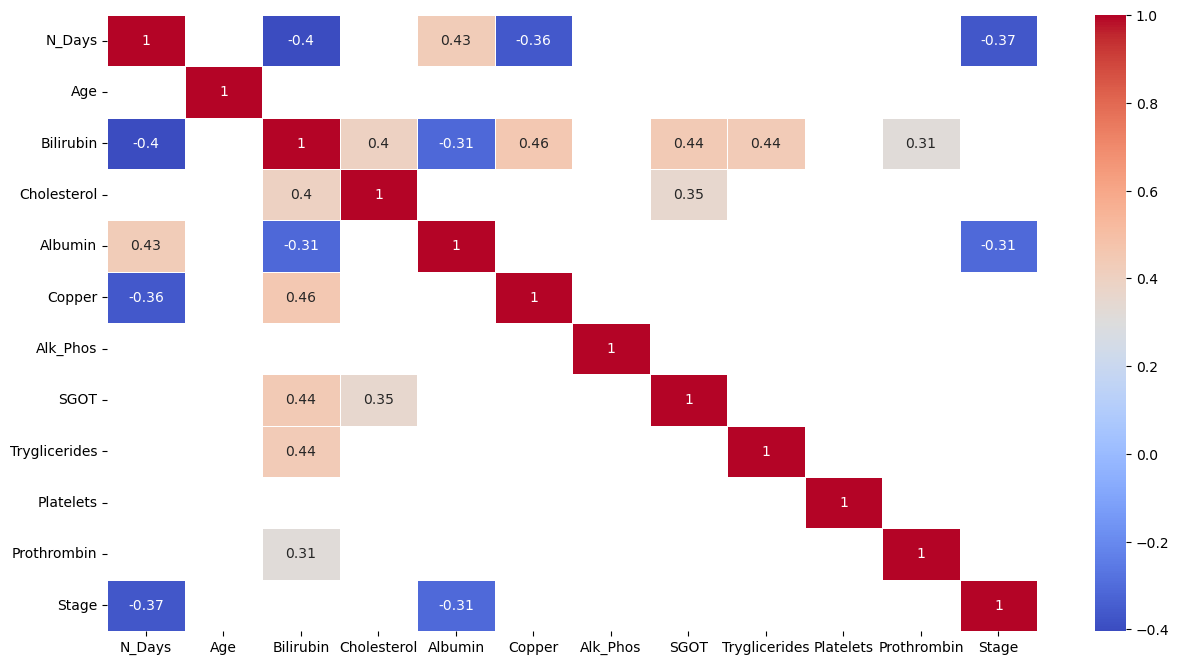

In [8]:
corr = df.corr(numeric_only=True);

# make the heatmap bigger
plt.figure(figsize=(15, 8));

sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5, mask=np.abs(corr) < .3);

### Check for nulls &c.

In [9]:
# According to the data source:
# Was there any data preprocessing performed?

# 1. Drop all the rows where miss value (NA) were present in the Drug column
# 2. Impute missing values with mean results
# 3. One-hot encoding for all category attributes

df = df.dropna(subset=['Drug'])
df.isna().sum()

N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

### Drop some columns

In [10]:
# I wonder if the remaining missing values are in the same rows

na_df = df[(df['Cholesterol'].isna()) | (df['Tryglicerides'].isna()) | (df['Platelets'].isna())]

In [11]:
na_df.shape
# Looks like, so let's try dropping them

(34, 19)

In [12]:
df = df.dropna()
df.isna().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [13]:
df.duplicated().sum()

0

## Modelling

In [14]:
# Split the data into features and target
X = df.drop(columns='Status')
y = df['Status'] 

X.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
293,1302,D-penicillamine,22111,M,N,Y,N,N,6.6,1000.0,3.07,88.0,3150.0,193.00,133.0,299.0,10.9,4.0
266,179,D-penicillamine,25899,F,Y,Y,Y,Y,6.6,222.0,2.33,138.0,620.0,106.00,91.0,195.0,12.1,4.0
35,3611,Placebo,20604,F,N,N,N,N,0.3,172.0,3.39,18.0,558.0,71.30,96.0,311.0,10.6,2.0
183,974,Placebo,13736,F,N,Y,N,N,11.0,674.0,3.55,358.0,2412.0,167.40,140.0,471.0,9.8,3.0
169,2692,D-penicillamine,17774,F,N,N,N,N,1.2,390.0,3.61,32.0,1509.0,88.35,52.0,263.0,9.0,3.0


In [16]:
ohe = OneHotEncoder(drop='first')
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [17]:
col_transformer = ColumnTransformer([('ohe', ohe, X_train.select_dtypes('object').columns.tolist()),
                                     ('number', scaler, X_train.select_dtypes('number').columns.tolist())])

col_transformer

ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('number', StandardScaler(),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])])

In [18]:
col_transformer.fit(X_train)
X_train_trans = col_transformer.transform(X_train)
X_test_trans = col_transformer.transform(X_test)


In [19]:
knn.fit(X_train_trans, y_train)

KNeighborsClassifier()

## Evaluate

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.92      0.82       117
          CL       0.80      0.22      0.35        18
           D       0.84      0.69      0.76        85

    accuracy                           0.78       220
   macro avg       0.80      0.61      0.64       220
weighted avg       0.79      0.78      0.76       220



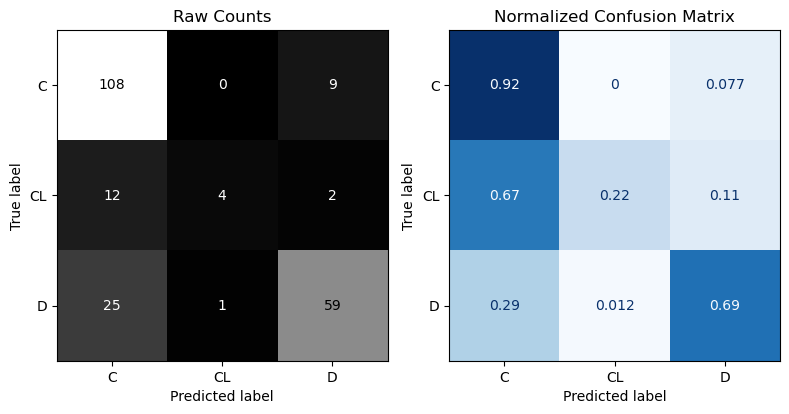


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.77      1.00      0.87        30
          CL       0.00      0.00      0.00         0
           D       1.00      0.62      0.76        26

    accuracy                           0.82        56
   macro avg       0.59      0.54      0.54        56
weighted avg       0.88      0.82      0.82        56



c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


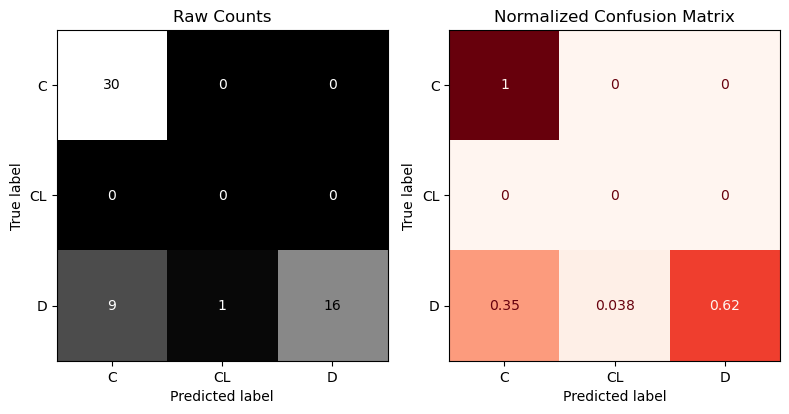

c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.92      0.82       117
          CL       0.80      0.22      0.35        18
           D       0.84      0.69      0.76        85

    accuracy                           0.78       220
   macro avg       0.80      0.61      0.64       220
weighted avg       0.79      0.78      0.76       220



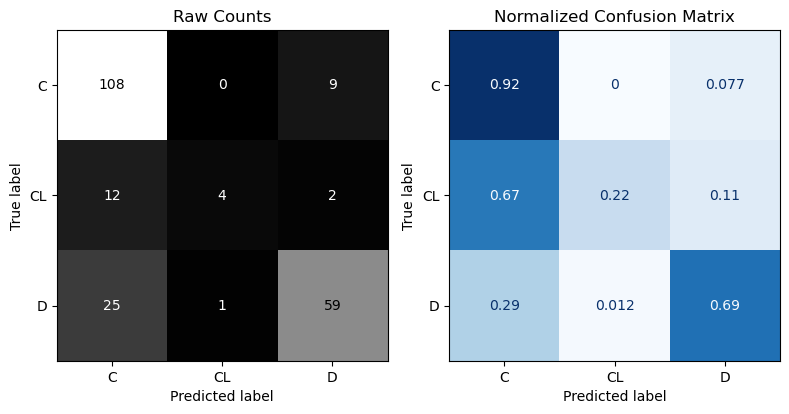


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.77      1.00      0.87        30
          CL       0.00      0.00      0.00         0
           D       1.00      0.62      0.76        26

    accuracy                           0.82        56
   macro avg       0.59      0.54      0.54        56
weighted avg       0.88      0.82      0.82        56



c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


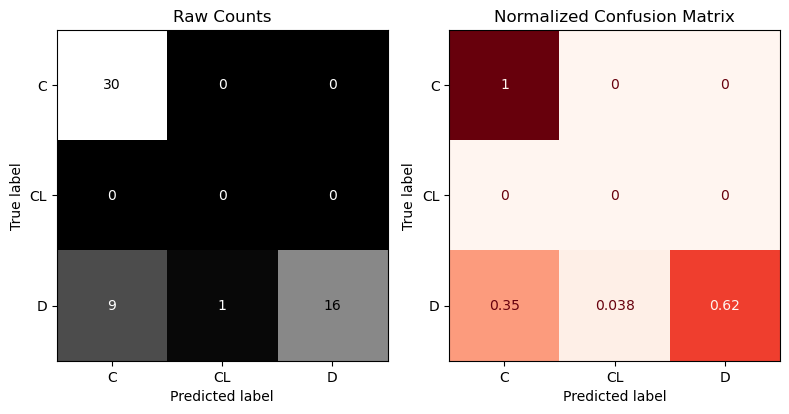

c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
drop_eval = evaluate_classification(knn, X_train_trans, y_train,
                                    X_test_trans, y_test,
                                    
                                    figsize=(8,4), normalize='true', output_dict = True);

evaluate_classification(knn, X_train_trans, y_train,
                        X_test_trans, y_test,
                        
                        figsize=(8,4), normalize='true', output_dict = False);

# Model 2 - imputing na rows

In [21]:
df_imputing = original_df.copy()
df_imputing.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [22]:
df_imputing = df_imputing.dropna(subset=['Drug'])
df_imputing.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [23]:
df_imputing.isna().sum()

ID                0
N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

In [24]:
df_imputing = df_imputing.drop(columns=['ID'])
df_imputing.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## train/test split

In [25]:
X_imputing = df_imputing.drop(columns='Status')
y_imputing = df_imputing['Status']

X_train_imputing, X_test_imputing, y_train_imputing, y_test_imputing = train_test_split(X_imputing, y_imputing, test_size=0.2, random_state=42)
X_train_imputing.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
111,3445,Placebo,20256,F,N,Y,Y,N,2.0,267.0,3.67,89.0,754.0,196.85,90.0,136.0,11.8,4.0
208,2216,Placebo,19221,F,N,Y,Y,N,0.7,252.0,4.01,11.0,1210.0,72.85,58.0,309.0,9.5,2.0
145,2615,Placebo,12369,F,N,N,N,S,1.2,NaN,3.89,58.0,1284.0,173.60,NaN,239.0,9.4,3.0
203,2090,Placebo,22857,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,281.0,10.2,3.0
78,3707,D-penicillamine,16990,F,N,Y,N,N,0.8,315.0,4.24,13.0,1637.0,170.50,70.0,426.0,10.9,3.0


## Piplines

In [26]:
impute_mean = SimpleImputer(strategy='mean')
ohe_imputing = OneHotEncoder(drop='first', sparse_output=False)
scale_imputing = StandardScaler()

ohe_cols_imputing = X_train_imputing.select_dtypes('object').columns.tolist()
num_cols_imputing = X_train_imputing.select_dtypes('number').columns.tolist()

ohe_cols_imputing, num_cols_imputing

(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'],
 ['N_Days',
  'Age',
  'Bilirubin',
  'Cholesterol',
  'Albumin',
  'Copper',
  'Alk_Phos',
  'SGOT',
  'Tryglicerides',
  'Platelets',
  'Prothrombin',
  'Stage'])

In [27]:
constant_imputer_imputing = SimpleImputer(strategy='constant', fill_value='NA')

In [28]:
ohe_pipe_imputing = make_pipeline(constant_imputer_imputing, ohe_imputing)
num_pipe_imputing = make_pipeline(impute_mean, scale_imputing)

ohe_tuple_imputing = ('ohe_imputing', ohe_pipe_imputing, ohe_cols_imputing)
num_tuple_imputing = ('num_imputing', num_pipe_imputing, num_cols_imputing)

In [29]:
transformer_for_imputing = ColumnTransformer([ohe_tuple_imputing, num_tuple_imputing], verbose_feature_names_out=False)
transformer_for_imputing

ColumnTransformer(transformers=[('ohe_imputing',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num_imputing',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [30]:
transformer_for_imputing.fit(X_train_imputing)

ColumnTransformer(transformers=[('ohe_imputing',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num_imputing',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [31]:
X_train_imputing_trans = transformer_for_imputing.transform(X_train_imputing)
X_test_imputing_trans = transformer_for_imputing.transform(X_test_imputing)

## Fit and Model

In [32]:
knn_imputing = KNeighborsClassifier()

In [33]:
knn_imputing.fit(X_train_imputing_trans, y_train_imputing)

KNeighborsClassifier()

## Evaluate

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.78      0.94      0.85       139
          CL       0.50      0.18      0.27        11
           D       0.86      0.66      0.74        99

    accuracy                           0.80       249
   macro avg       0.71      0.59      0.62       249
weighted avg       0.79      0.80      0.78       249



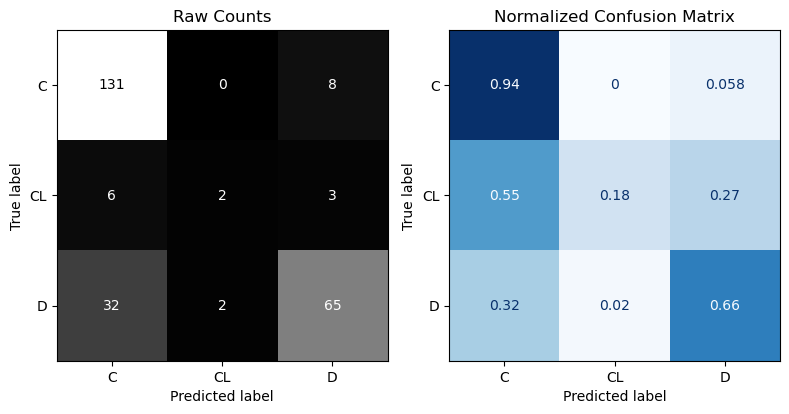


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.66      0.93      0.77        29
          CL       1.00      0.12      0.22         8
           D       0.86      0.69      0.77        26

    accuracy                           0.73        63
   macro avg       0.84      0.58      0.59        63
weighted avg       0.78      0.73      0.70        63



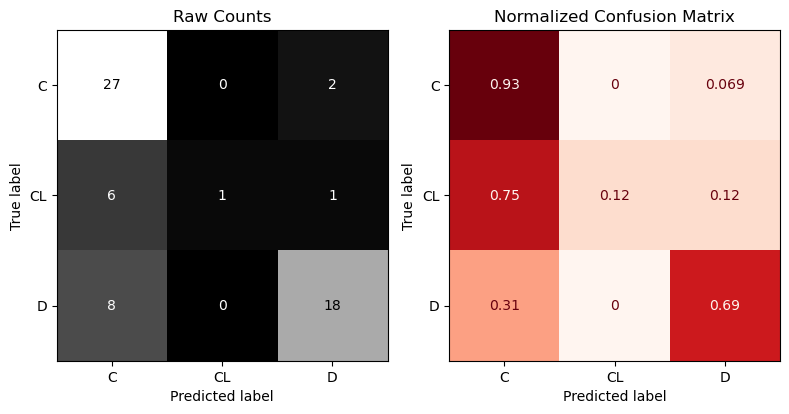

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.78      0.94      0.85       139
          CL       0.50      0.18      0.27        11
           D       0.86      0.66      0.74        99

    accuracy                           0.80       249
   macro avg       0.71      0.59      0.62       249
weighted avg       0.79      0.80      0.78       249



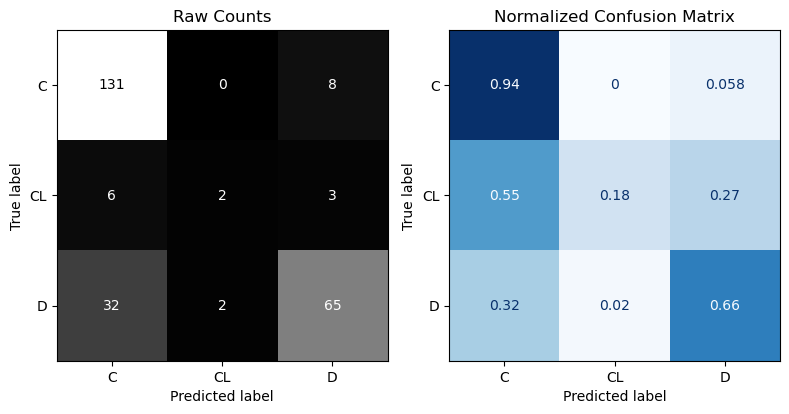


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.66      0.93      0.77        29
          CL       1.00      0.12      0.22         8
           D       0.86      0.69      0.77        26

    accuracy                           0.73        63
   macro avg       0.84      0.58      0.59        63
weighted avg       0.78      0.73      0.70        63



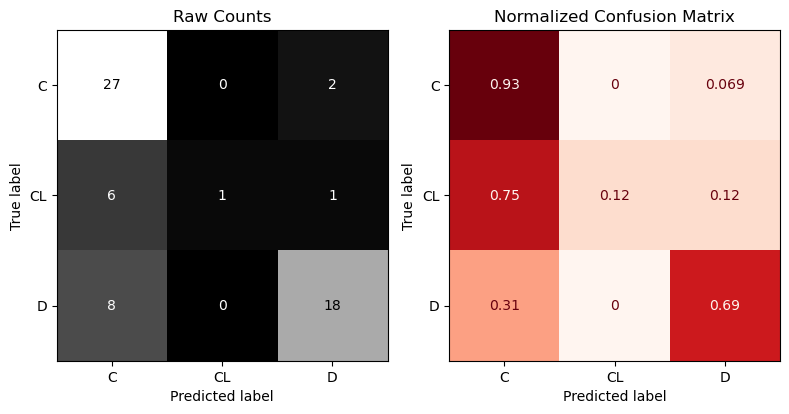

In [34]:
impute_eval = evaluate_classification(knn_imputing, X_train_imputing_trans, y_train_imputing, X_test_imputing_trans, y_test_imputing, figsize=(8,4), normalize='true', output_dict = True);

evaluate_classification(knn_imputing, X_train_imputing_trans, y_train_imputing, X_test_imputing_trans, y_test_imputing, figsize=(8,4), normalize='true', output_dict = True);

# Compare

## First Model

 Classification Metrics: Training Data
 
              precision    recall  f1-score   support

           C       0.76      0.94      0.84       117
          CL       0.33      0.06      0.10        18
           D       0.86      0.74      0.80        85

    accuracy                           0.79       220
   macro avg       0.65      0.58      0.58       220
weighted avg       0.77      0.79      0.76       220



 Classification Metrics: Test Data
 
              precision    recall  f1-score   support

           C       0.81      1.00      0.90        30
          CL       0.00      0.00      0.00         0
           D       1.00      0.69      0.82        26

    accuracy                           0.86        56
   macro avg       0.60      0.56      0.57        56
weighted avg       0.90      0.86      0.86        56


## Second Model

 Classification Metrics: Training Data
 
              precision    recall  f1-score   support

           C       0.74      0.94      0.83       117
          CL       0.33      0.06      0.10        18
           D       0.87      0.71      0.78        85

    accuracy                           0.78       220
   macro avg       0.65      0.57      0.57       220
weighted avg       0.76      0.78      0.75       220

 Classification Metrics: Test Data
 
              precision    recall  f1-score   support

           C       0.81      1.00      0.90        30
           D       1.00      0.73      0.84        26

    accuracy                           0.88        56
   macro avg       0.91      0.87      0.87        56
weighted avg       0.90      0.88      0.87        56

## Thoughts

Interesting that CL is missing from only Model 2's test performance

In [35]:
e_df = original_df.dropna(subset=['Drug'])
e_df.isna().sum()

ID                0
N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

In [36]:
na_df = e_df[(e_df['Cholesterol'].isna()) | (e_df['Tryglicerides'].isna()) | (e_df['Platelets'].isna())]
na_df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
13,14,1217,D,Placebo,20535,M,Y,Y,N,Y,0.8,NaN,2.27,43.0,728.0,71.00,NaN,156.0,11.0,4.0
39,40,4467,C,D-penicillamine,17046,F,N,N,N,N,1.3,NaN,3.34,105.0,11046.6,104.49,NaN,358.0,11.0,4.0
40,41,1350,D,D-penicillamine,12285,F,N,Y,N,N,6.8,NaN,3.26,96.0,1215.0,151.90,NaN,226.0,11.7,4.0
41,42,4453,C,Placebo,12307,F,N,Y,Y,N,2.1,NaN,3.54,122.0,8778.0,56.76,NaN,344.0,11.0,4.0


In [37]:
na_df['Status'].value_counts()

C     20
D     13
CL     1
Name: Status, dtype: int64

In [38]:
na_df.loc[na_df['Status'] == 'CL']
## okay, it was just because only one patient had a liver transplant AND had missing values

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
273,274,1447,CL,D-penicillamine,17525,F,N,N,N,N,1.6,NaN,3.07,136.0,1995.0,128.0,NaN,372.0,9.6,4.0


Maybe I should drop the CL tables, since there are so many outside factors that influence whether someone gets a transplant or not

In [39]:
e_df['Status'].value_counts()

C     168
D     125
CL     19
Name: Status, dtype: int64

In [40]:
19 / (168 + 125 + 19)

0.060897435897435896

# Model 3 - Dropping only CL rows

In [41]:
df_no_cl = original_df.copy()
df_no_cl.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [42]:
df_no_cl = df_no_cl.loc[df_no_cl['Status'] != 'CL']
df_no_cl.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0


In [43]:
df_no_cl['Status'].value_counts()

C    232
D    161
Name: Status, dtype: int64

In [44]:
df_no_cl.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             100
Age                0
Sex                0
Ascites          100
Hepatomegaly     100
Spiders          100
Edema              0
Bilirubin          0
Cholesterol      127
Albumin            0
Copper           102
Alk_Phos         100
SGOT             100
Tryglicerides    129
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [45]:
df_no_cl = df_no_cl.drop(columns=['ID'])
df_no_cl.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0


## train/test split

In [46]:
X_imputing_no_cl = df_no_cl.drop(columns='Status')
y_imputing_no_cl = df_no_cl['Status']

X_train_imputing_no_cl, X_test_imputing_no_cl, y_train_imputing_no_cl, y_test_imputing_no_cl = train_test_split(X_imputing_no_cl, y_imputing_no_cl, test_size=0.2, random_state=42)
X_train_imputing_no_cl.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
349,662,NaN,17532,F,NaN,NaN,NaN,N,2.1,NaN,4.10,NaN,NaN,NaN,NaN,200.0,9.0,3.0
189,2504,D-penicillamine,19916,F,N,N,Y,N,2.3,NaN,3.93,24.0,1828.0,133.30,NaN,327.0,10.2,2.0
178,2573,Placebo,16050,F,N,Y,N,N,1.8,396.0,3.83,39.0,2148.0,102.30,133.0,278.0,9.9,4.0
64,3992,D-penicillamine,14684,F,N,N,N,N,1.2,256.0,3.60,74.0,724.0,141.05,108.0,430.0,10.0,1.0
363,359,NaN,21550,F,NaN,NaN,NaN,N,2.7,NaN,3.35,NaN,NaN,NaN,NaN,142.0,11.5,4.0


## Piplines

In [47]:
impute_mean_no_cl = SimpleImputer(strategy='mean')
ohe_no_cl = OneHotEncoder(drop='first', sparse_output=False)
scale_no_cl = StandardScaler()

ohe_cols_no_cl = X_train_imputing_no_cl.select_dtypes('object').columns.tolist()
num_cols_no_cl = X_train_imputing_no_cl.select_dtypes('number').columns.tolist()

ohe_cols_no_cl, num_cols_no_cl

(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'],
 ['N_Days',
  'Age',
  'Bilirubin',
  'Cholesterol',
  'Albumin',
  'Copper',
  'Alk_Phos',
  'SGOT',
  'Tryglicerides',
  'Platelets',
  'Prothrombin',
  'Stage'])

In [48]:
constant_imputer_no_cl = SimpleImputer(strategy='constant', fill_value='NA')

In [49]:
ohe_pipe_no_cl = make_pipeline(constant_imputer_no_cl, ohe_no_cl)
num_pipe_no_cl = make_pipeline(impute_mean_no_cl, scale_no_cl)

ohe_tuple_no_cl = ('ohe', ohe_pipe_no_cl, ohe_cols_no_cl)
num_tuple_no_cl = ('num', num_pipe_no_cl, num_cols_no_cl)

In [50]:
transformer_for_imputing_no_cl = ColumnTransformer([ohe_tuple_no_cl, num_tuple_no_cl], verbose_feature_names_out=False)
transformer_for_imputing_no_cl

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [51]:
transformer_for_imputing_no_cl.fit(X_train_imputing_no_cl)

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [52]:
X_train_imputing_trans_no_cl = transformer_for_imputing_no_cl.transform(X_train_imputing_no_cl)
X_test_imputing_trans_no_cl = transformer_for_imputing_no_cl.transform(X_test_imputing_no_cl)

## Fit and Model

In [53]:
knn_imputing_no_cl = KNeighborsClassifier()

In [54]:
knn_imputing_no_cl.fit(X_train_imputing_trans_no_cl, y_train_imputing_no_cl)

KNeighborsClassifier()

## Evaluate

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.82      0.94      0.88       193
           D       0.88      0.68      0.77       121

    accuracy                           0.84       314
   macro avg       0.85      0.81      0.82       314
weighted avg       0.85      0.84      0.84       314



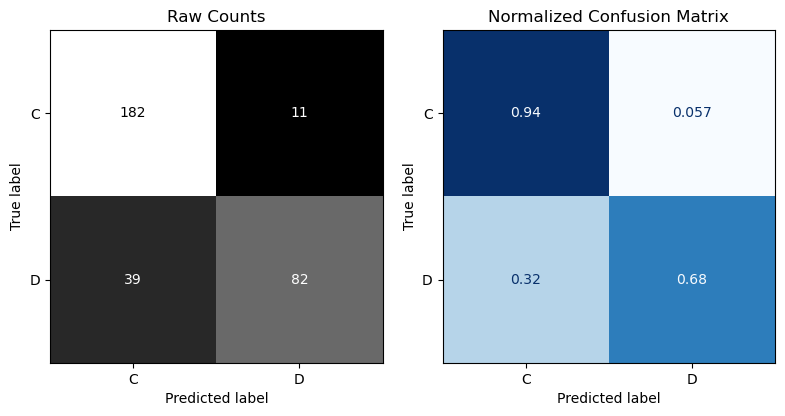


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.82      0.78        39
           D       0.81      0.72      0.76        40

    accuracy                           0.77        79
   macro avg       0.77      0.77      0.77        79
weighted avg       0.78      0.77      0.77        79



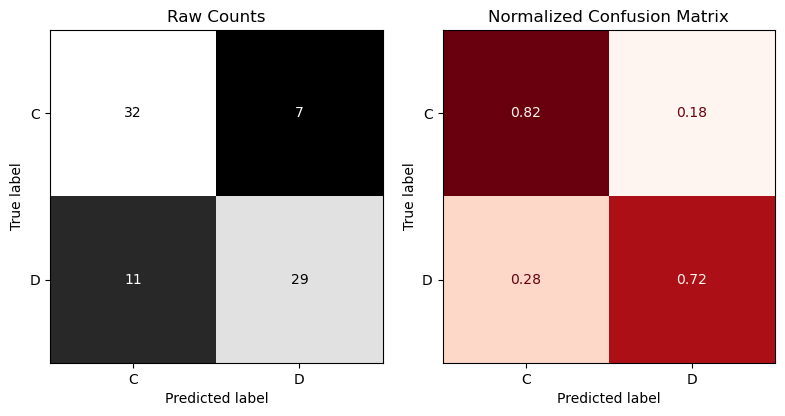

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.82      0.94      0.88       193
           D       0.88      0.68      0.77       121

    accuracy                           0.84       314
   macro avg       0.85      0.81      0.82       314
weighted avg       0.85      0.84      0.84       314



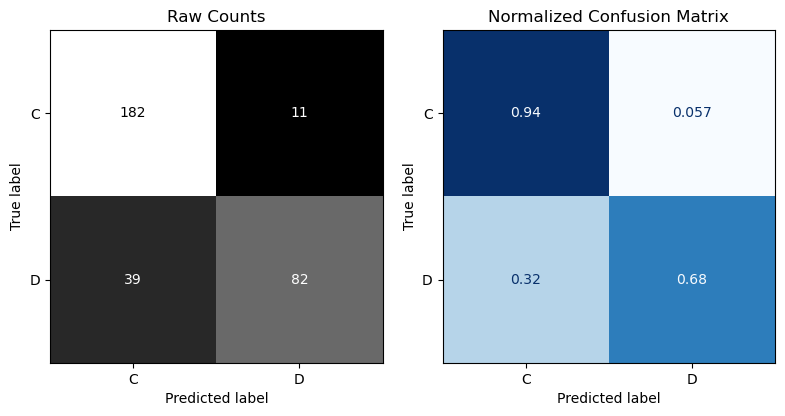


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.82      0.78        39
           D       0.81      0.72      0.76        40

    accuracy                           0.77        79
   macro avg       0.77      0.77      0.77        79
weighted avg       0.78      0.77      0.77        79



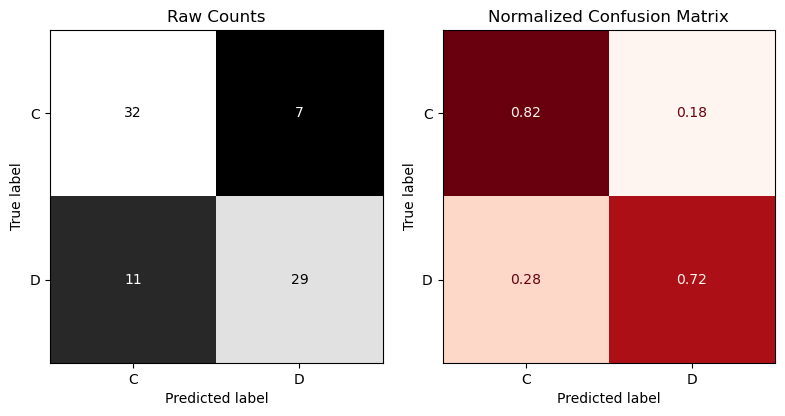

In [55]:
no_cls_eval = evaluate_classification(knn_imputing_no_cl,
                                      
                                      X_train_imputing_trans_no_cl, y_train_imputing_no_cl,
                                      X_test_imputing_trans_no_cl, y_test_imputing_no_cl,
                                      
                                      figsize=(8,4), normalize='true', output_dict = True);

evaluate_classification(knn_imputing_no_cl,
                        
                        X_train_imputing_trans_no_cl, y_train_imputing_no_cl,
                        X_test_imputing_trans_no_cl, y_test_imputing_no_cl, figsize=(8,4),

                        normalize='true', output_dict = False);

# Compare the results of the three models

In [56]:
def compare_evaluations(drop_eval, impute_eval, no_cls_eval):
  drop_df = pd.DataFrame(drop_eval).T
  impute_df = pd.DataFrame(impute_eval).T
  no_cls_df = pd.DataFrame(no_cls_eval).T


  combined_df = pd.concat([drop_df, impute_df, no_cls_df])
  return combined_df

combined_df = compare_evaluations(drop_eval, impute_eval, no_cls_eval)
combined_df.head()

,C,CL,D,accuracy,macro avg,weighted avg
train,"{'precision': 0.7448275862068966, 'recall': 0....","{'precision': 0.8, 'recall': 0.222222222222222...","{'precision': 0.8428571428571429, 'recall': 0....",0.777273,"{'precision': 0.7958949096880131, 'recall': 0....","{'precision': 0.7872167487684729, 'recall': 0...."
test,"{'precision': 0.7692307692307693, 'recall': 1....","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 1.0, 'recall': 0.615384615384615...",0.821429,"{'precision': 0.5897435897435898, 'recall': 0....","{'precision': 0.8763736263736265, 'recall': 0...."
train,"{'precision': 0.7751479289940828, 'recall': 0....","{'precision': 0.5, 'recall': 0.181818181818181...","{'precision': 0.8552631578947368, 'recall': 0....",0.795181,"{'precision': 0.71013702896294, 'recall': 0.59...","{'precision': 0.7948458424166925, 'recall': 0...."
test,"{'precision': 0.6585365853658537, 'recall': 0....","{'precision': 1.0, 'recall': 0.125, 'f1-score'...","{'precision': 0.8571428571428571, 'recall': 0....",0.730159,"{'precision': 0.8385598141695704, 'recall': 0....","{'precision': 0.7838615120845086, 'recall': 0...."
train,"{'precision': 0.8235294117647058, 'recall': 0....",NaN,"{'precision': 0.8817204301075269, 'recall': 0....",0.840764,"{'precision': 0.8526249209361163, 'recall': 0....","{'precision': 0.8459533392152834, 'recall': 0...."


In [57]:
pd.DataFrame(drop_eval['test'])


,C,CL,D,accuracy,macro avg,weighted avg
precision,0.769231,0.0,1.000000,0.821429,0.589744,0.876374
recall,1.000000,0.0,0.615385,0.821429,0.538462,0.821429
f1-score,0.869565,0.0,0.761905,0.821429,0.543823,0.819580
support,30.000000,0.0,26.000000,0.821429,56.000000,56.000000


In [58]:
pd.DataFrame(impute_eval['test'])


,C,CL,D,accuracy,macro avg,weighted avg
precision,0.658537,1.000000,0.857143,0.730159,0.838560,0.783862
recall,0.931034,0.125000,0.692308,0.730159,0.582781,0.730159
f1-score,0.771429,0.222222,0.765957,0.730159,0.586536,0.699430
support,29.000000,8.000000,26.000000,0.730159,63.000000,63.000000


In [59]:
pd.DataFrame(no_cls_eval['test'])

,C,D,accuracy,macro avg,weighted avg
precision,0.744186,0.805556,0.772152,0.774871,0.775259
recall,0.820513,0.725000,0.772152,0.772756,0.772152
f1-score,0.780488,0.763158,0.772152,0.771823,0.771713
support,39.000000,40.000000,0.772152,79.000000,79.000000


Accuracy

In [60]:
drop_eval['test']['accuracy'], impute_eval['test']['accuracy'], no_cls_eval['test']['accuracy'],
drop_eval['test']['accuracy'], impute_eval['test']['accuracy'], no_cls_eval['test']['accuracy'],
drop_eval['test']['accuracy'], impute_eval['test']['accuracy'], no_cls_eval['test']['accuracy']

(0.8214285714285714, 0.7301587301587301, 0.7721518987341772)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.82      0.94      0.88       193
           D       0.88      0.68      0.77       121

    accuracy                           0.84       314
   macro avg       0.85      0.81      0.82       314
weighted avg       0.85      0.84      0.84       314



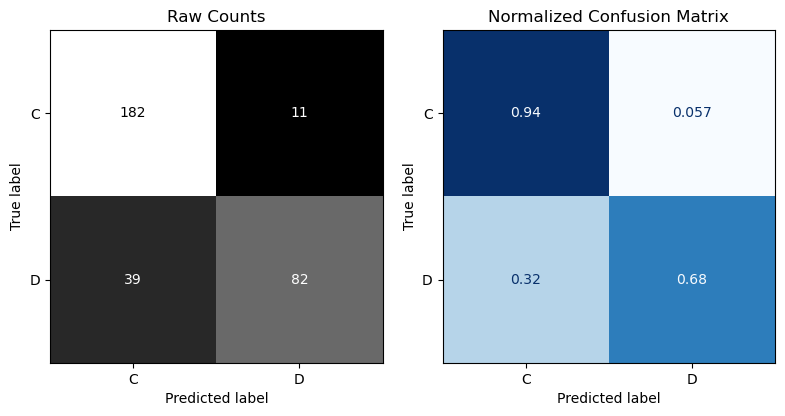


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.82      0.78        39
           D       0.81      0.72      0.76        40

    accuracy                           0.77        79
   macro avg       0.77      0.77      0.77        79
weighted avg       0.78      0.77      0.77        79



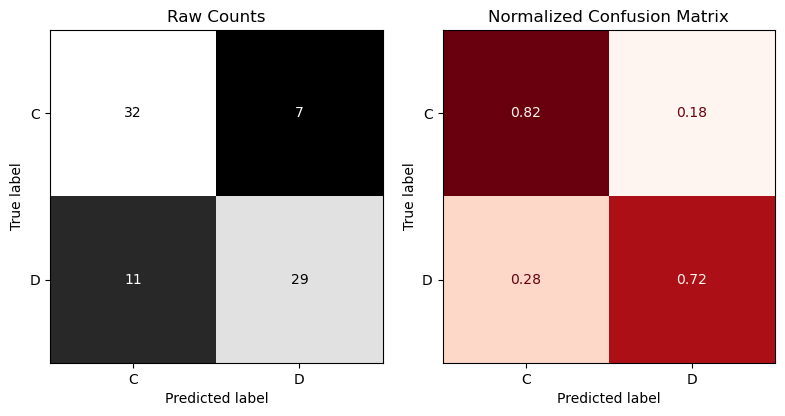

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.82      0.94      0.88       193
           D       0.88      0.68      0.77       121

    accuracy                           0.84       314
   macro avg       0.85      0.81      0.82       314
weighted avg       0.85      0.84      0.84       314



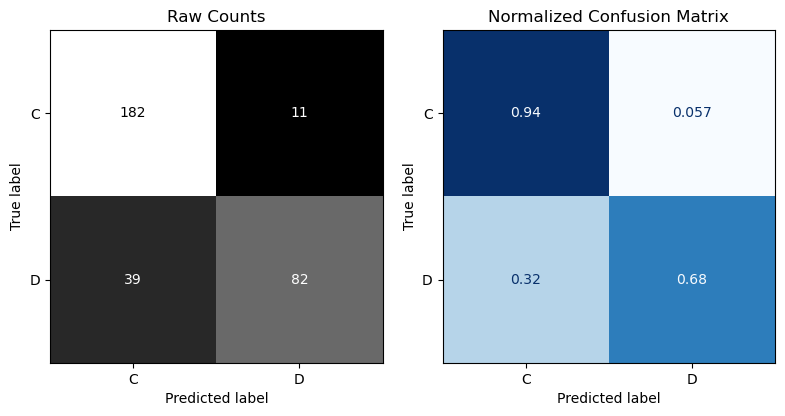


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.82      0.78        39
           D       0.81      0.72      0.76        40

    accuracy                           0.77        79
   macro avg       0.77      0.77      0.77        79
weighted avg       0.78      0.77      0.77        79



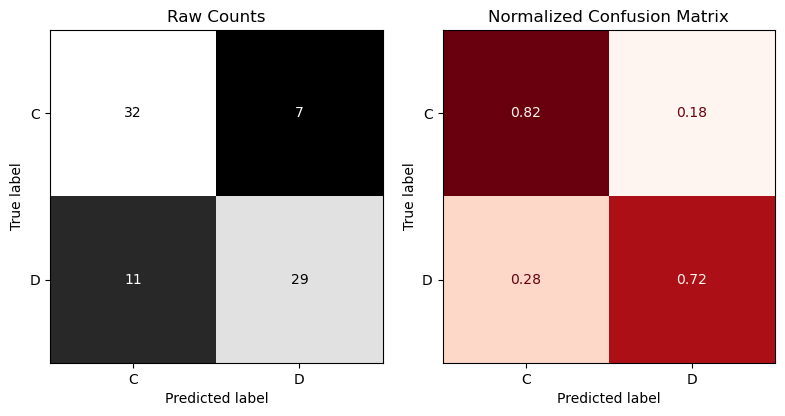

In [61]:
no_cls_eval = evaluate_classification(knn_imputing_no_cl,
                                      
                                      X_train_imputing_trans_no_cl, y_train_imputing_no_cl,
                                      X_test_imputing_trans_no_cl, y_test_imputing_no_cl,
                                      
                                            figsize=(8,4), normalize='true', output_dict = True);

evaluate_classification(knn_imputing_no_cl,
                        
                        X_train_imputing_trans_no_cl, y_train_imputing_no_cl,
                        X_test_imputing_trans_no_cl, y_test_imputing_no_cl, figsize=(8,4),

                        normalize='true', output_dict = False);

In [62]:
pd.DataFrame(drop_eval).T.C['test']['precision'], pd.DataFrame(impute_eval).T.C['test']['precision'], pd.DataFrame(no_cls_eval).T.C['test']['precision']

(0.7692307692307693, 0.6585365853658537, 0.7441860465116279)

# Insights

## Extract and visualize the top 10 features using permutation importance

In [64]:
from sklearn.inspection import permutation_importance
from sklearn import set_config

set_config(transform_output='pandas')

# Perform permutation importance

result = permutation_importance(knn_imputing, X_train_imputing_trans, y_train_imputing_no_cl, n_repeats=10, random_state=42)
# ValueError: Found input variables with inconsistent numbers of samples: [314, 249]


# Get the top 10 features
top_features_idx = result.importances_mean.argsort()[-10:]

# # Get the names of the top 10 features
# top_features_names = X_train_imputing_trans.columns[top_features_idx]

# # Visualize the top 10 features
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(top_features_names)), result.importances_mean[top_features_idx], xerr=result.importances_std[top_features_idx])
# plt.yticks(range(len(top_features_names)), top_features_names)
# plt.xlabel('Permutation Importance')
# plt.ylabel('Feature')
# plt.title('Top 10 Features based on Permutation Importance')
# plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [314, 249]

In [ ]:
result.importances_mean

array([-0.00843373,  0.0060241 ,  0.00361446, -0.00240964, -0.00281124,
        0.00080321, -0.00040161,  0.02650602, -0.00361446,  0.01204819,
        0.00361446,  0.00080321,  0.01285141,  0.02449799,  0.00522088,
        0.00562249,  0.00722892,  0.01445783,  0.01285141])

In [ ]:
top_features_names

Int64Index([14, 15, 1, 16, 9, 12, 18, 17, 13, 7], dtype='int64')

In [ ]:
# Add your observations in a Markdown: Do these features make sense based on the business case?
# Create Explanatory Visualizations for the most important features.
# Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
# The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.
# These visuals should be reporting-quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the insight associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither of these should be histograms, boxplots, or correlation plots).
# These will be added to your readme in part 4